In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [1]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.9.1
2.9.0


In [2]:
initLayer = 1e-4
epochs = 5
batch = 32

In [5]:
dirc = 'DataSet'
cat = ['withMask','withoutMask']
data = []
labels = []
for cate in cat:
    path = os.path.join(dirc,cate)
    for img in os.listdir(path):
        img_path = os.path.join(path,img)
        image = load_img(img_path,target_size=(224,224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(cate)

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
data = np.array(data,dtype='float32')
labels = np.array(labels)

In [8]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [10]:
X_train,X_test,y_train,y_test = train_test_split(data,labels,test_size=0.2,stratify=labels,random_state=20)

In [13]:
X_train

array([[[[ 1.        ,  0.96862745,  1.        ],
         [ 0.9529412 ,  1.        ,  1.        ],
         [ 0.94509804,  1.        ,  1.        ],
         ...,
         [ 0.99215686,  1.        ,  1.        ],
         [ 0.99215686,  1.        ,  1.        ],
         [ 0.99215686,  1.        ,  1.        ]],

        [[ 0.92941177,  1.        ,  0.94509804],
         [ 0.81960785,  1.        ,  0.94509804],
         [ 0.8117647 ,  1.        ,  0.92941177],
         ...,
         [ 0.79607844,  1.        ,  0.8980392 ],
         [ 0.7882353 ,  1.        ,  0.8901961 ],
         [ 0.79607844,  1.        ,  0.9137255 ]],

        [[ 0.39607847,  0.92941177,  0.62352943],
         [-0.11372548,  0.58431375,  0.22352946],
         [-0.09803921,  0.6313726 ,  0.26274514],
         ...,
         [-0.27843136,  0.45882356,  0.04313731],
         [-0.29411763,  0.4431373 ,  0.03529418],
         [-0.27843136,  0.45882356,  0.06666672]],

        ...,

        [[-0.03529412,  0.03529418,  0

In [14]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [17]:
baseModel = MobileNetV2(weights="imagenet",include_top=False,input_tensor=Input(shape=(224,224,3)))

9406464/9406464 [==============================] - 1s 0us/step


In [18]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size = (7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128,activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2,activation="softmax")(headModel)

In [20]:
model = Model(inputs=baseModel.input,outputs=headModel)

In [21]:
for layers in baseModel.layers:
    layers.trainable = False

In [22]:
model.compile(loss="binary_crossentropy",
              optimizer=Adam(learning_rate=initLayer,decay=initLayer/epochs),
              metrics=["accuracy"]
             )

In [23]:
MOD = model.fit(aug.flow(X_train,y_train,batch_size=batch),
               steps_per_epoch=len(X_train)//batch,
                validation_data=(X_test,y_test),
                validation_steps=len(X_test)//batch,
                epochs=epochs
               )

Epoch 1/5
95/95 [==============================] - 235s 2s/step - loss: 0.4472 - accuracy: 0.8230 - val_loss: 0.1719 - val_accuracy: 0.9739
Epoch 2/5
95/95 [==============================] - 36s 374ms/step - loss: 0.1590 - accuracy: 0.9680 - val_loss: 0.0882 - val_accuracy: 0.9817
Epoch 3/5
95/95 [==============================] - 29s 301ms/step - loss: 0.1143 - accuracy: 0.9693 - val_loss: 0.0630 - val_accuracy: 0.9883
Epoch 4/5
95/95 [==============================] - 29s 300ms/step - loss: 0.0940 - accuracy: 0.9723 - val_loss: 0.0518 - val_accuracy: 0.9883
Epoch 5/5
95/95 [==============================] - 28s 299ms/step - loss: 0.0731 - accuracy: 0.9815 - val_loss: 0.0450 - val_accuracy: 0.9883


In [24]:
model.save("mask_detection.model",save_format="h5")

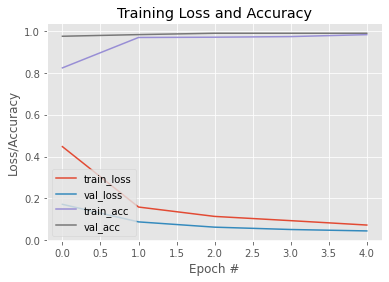

In [27]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), MOD.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), MOD.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), MOD.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), MOD.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# plt.savefig("plot.png")